In [1]:
%matplotlib inline
%load_ext rpy2.ipython
from ml import query
import math
from pbto2 import data

In [2]:
import imp
imp.reload(data)

<module 'pbto2.data' from '/Users/eczech/repos/portfolio/functional/ml/python/pbto2/data.py'>

In [3]:
#d = pd.read_pickle('/Users/eczech/data/ptbo2/export/data_features.pkl')
d_raw = data.get_raw_data()
d = data.get_raw_feature_data(d_raw)
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 0 to 338
Columns: 189 entries, uid to gos-24-alive
dtypes: float64(188), int64(1)
memory usage: 503.2 KB


In [4]:
d[[c for c in d if 'pbto2_pct_in_range_' in c]].head()

feature,pbto2_pct_in_range_hi,pbto2_pct_in_range_lo,pbto2_pct_in_range_mi
0,0.045455,0.000000,0.954545
1,0.000000,0.153846,0.846154
2,0.265625,0.000000,0.734375
3,0.000000,0.389831,0.610169
4,0.031250,0.093750,0.875000


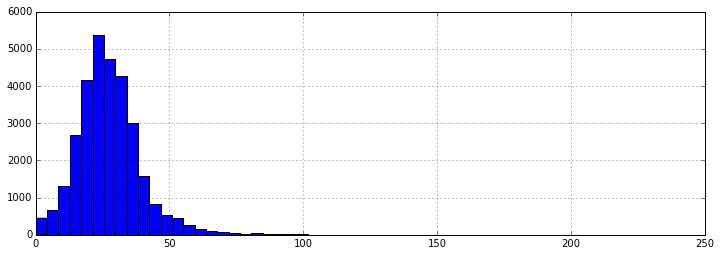

In [5]:
x = d_raw['pbto2']
x = x[x > 0]
#x[x > 0].plot(kind='kde')
x.hist(bins=50, figsize=(12,4))

In [6]:
d[[c for c in d if 'gos' in c]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 0 to 338
Data columns (total 16 columns):
gos-12              259 non-null float64
gos-24              207 non-null float64
gos-3               272 non-null float64
gos-6               272 non-null float64
gos-3-favalive      201 non-null float64
gos-6-favalive      191 non-null float64
gos-12-favalive     175 non-null float64
gos-24-favalive     120 non-null float64
gos-3-favorable     272 non-null float64
gos-6-favorable     272 non-null float64
gos-12-favorable    259 non-null float64
gos-24-favorable    207 non-null float64
gos-3-alive         272 non-null float64
gos-6-alive         272 non-null float64
gos-12-alive        259 non-null float64
gos-24-alive        207 non-null float64
dtypes: float64(16)
memory usage: 45.0 KB


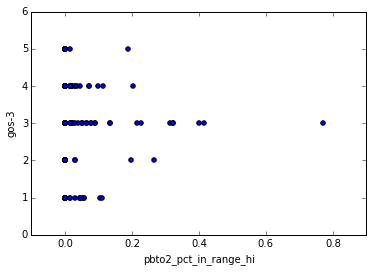

In [7]:
d.plot(kind='scatter', x='pbto2_pct_in_range_hi', y='gos-3')

In [8]:
d_plt = d[~d['gos-3'].isnull()]

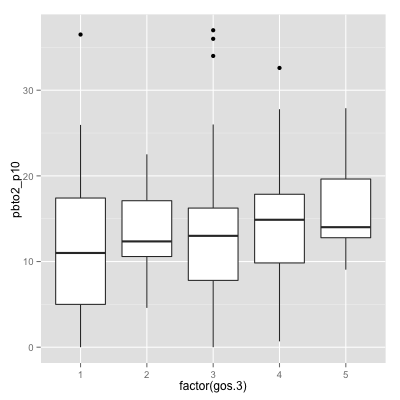

In [10]:
%%R -i d_plt -w 400 -h 400 -u px
library(ggplot2)
library(dplyr)
d_plt %>% select(gos.3, pbto2_p10) %>%
    mutate_each(funs(as.numeric)) %>%
    ggplot(aes(x=factor(gos.3), y=pbto2_p10)) + geom_boxplot()

Variable Interpretations:

    pao2: Partial pressure of oxygen (PaO2): 75 - 100 mmHg
    paco2: Partial pressure of carbon dioxide (PaCO2): 38 - 42 mmHg
    pha: Arterial blood pH: 7.38 - 7.42
    sao2: Oxygen saturation (SaO2): 94 - 100%
    hco3: Bicarbonate - (HCO3): 22 - 28 mEq/L

In [11]:
import imp
imp.reload(data)

<module 'pbto2.data' from '/Users/eczech/repos/portfolio/functional/ml/python/pbto2/data.py'>

In [13]:
outcome = 'gos-3-favorable'
feats = [
    ([outcome, 'uid', 'age', 'sex', 'gcs', 'marshall'],),
    #(['pbto2'], ['p10', 'std', 'mean', 'mean_under_.*', 'mean_over_.*']),
    (['pbto2'], ['ct_bin.*']),
    (['pao2', 'icp'], ['mean', 'p10', 'p990', 'std'])
]

d_in, n_frac = data.get_prepared_features(d, feats, outcome=outcome)

print('Feature NA fractions:')
print(n_frac)
print('---------------------')

d_in.info()

Feature NA fractions:
feature
pao2_mean            0.011799
pao2_p10             0.011799
pao2_p990            0.011799
pao2_std             0.017699
marshall             0.097345
gos-3-favorable      0.197640
__n_records__      339.000000
dtype: float64
---------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 272 entries, 461 to 1056
Data columns (total 16 columns):
age                272 non-null float64
gcs                272 non-null float64
marshall           272 non-null float64
pao2_mean          272 non-null float64
pao2_p10           272 non-null float64
pao2_p990          272 non-null float64
pao2_std           272 non-null float64
pbto2_ct_bin_01    272 non-null float64
pbto2_ct_bin_05    272 non-null float64
pbto2_ct_bin_10    272 non-null float64
pbto2_ct_bin_15    272 non-null float64
pbto2_ct_bin_20    272 non-null float64
pbto2_ct_bin_25    272 non-null float64
pbto2_ct_bin_30    272 non-null float64
sex                272 non-null float64
outcome        

In [14]:
# Export for MCMC fitting
d_in.reset_index().to_csv('/Users/eczech/data/ptbo2/export/data_modeling.csv', index=False)
#d_in.reset_index().to_csv('/Users/eczech/data/ptbo2/export/data_modeling_w_gos_interp.csv', index=False)

In [15]:
# from sklearn.manifold import TSNE
# tsne = TSNE()
# tsne = tsne.fit_transform(d_in)
# plt.scatter(tsne[:,0], tsne[:,1])

# Modeling

In [16]:
X, y = d_in[[c for c in d_in if c != 'outcome']], d_in['outcome']

In [17]:
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, PassiveAggressiveClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from ml.model import grids
from ml.model import models

#gbr_grid = grids.GBR_STANDARD_1
# gbr_grid = {
#     'learning_rate': [.1, .05, .02, .01],
#     'max_depth': [3, 7],
#     'min_samples_leaf': [3, 5, 9, 17],
#     'max_features': [1., .3, .1],
#     'n_estimators': [1000]
# }
gbr_grid = {
    'learning_rate': [.001],
    'n_estimators': [1000],
    'subsample': [.8]
}

clfs = {
    #'gbr': GridSearchCV(GradientBoostingClassifier(), gbr_grid, n_jobs=1),
    'gbr': GradientBoostingClassifier(n_estimators=50),
    'etr': ExtraTreesClassifier(),
    'l2_logit': LogisticRegressionCV(penalty='l2'),
    'l1_logit': LogisticRegression(penalty='l1', solver='liblinear'),
    'adaboost': AdaBoostClassifier(n_estimators=300),
    'rf': RandomForestClassifier(n_estimators=300)
}
cv = StratifiedKFold(y, 10, shuffle=True)
res = models.run_classifiers(X, y, clfs, cv, par_n_jobs=-1)

Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


INFO:ml.model.log:CV Complete (6 model(s) run)
INFO:ml.model.log:Running model etr (ExtraTreesClassifier) on fold 1
INFO:ml.model.log:Running model etr (ExtraTreesClassifier) on fold 2
INFO:ml.model.log:Running model etr (ExtraTreesClassifier) on fold 3
INFO:ml.model.log:Running model etr (ExtraTreesClassifier) on fold 4
INFO:ml.model.log:Running model etr (ExtraTreesClassifier) on fold 5
INFO:ml.model.log:Running model etr (ExtraTreesClassifier) on fold 6
INFO:ml.model.log:Running model etr (ExtraTreesClassifier) on fold 7
INFO:ml.model.log:Running model etr (ExtraTreesClassifier) on fold 8
INFO:ml.model.log:Running model l2_logit (LogisticRegressionCV) on fold 1
INFO:ml.model.log:Running model l2_logit (LogisticRegressionCV) on fold 2
INFO:ml.model.log:Running model l2_logit (LogisticRegressionCV) on fold 3
INFO:ml.model.log:Running model l2_logit (LogisticRegressionCV) on fold 4
INFO:ml.model.log:Running model l2_logit (LogisticRegressionCV) on fold 5
INFO:ml.model.log:Running model

In [34]:
from ml.model import summaries as ml_precis
ml_precis.summarize_grid_parameters(res)

### ROC Curves

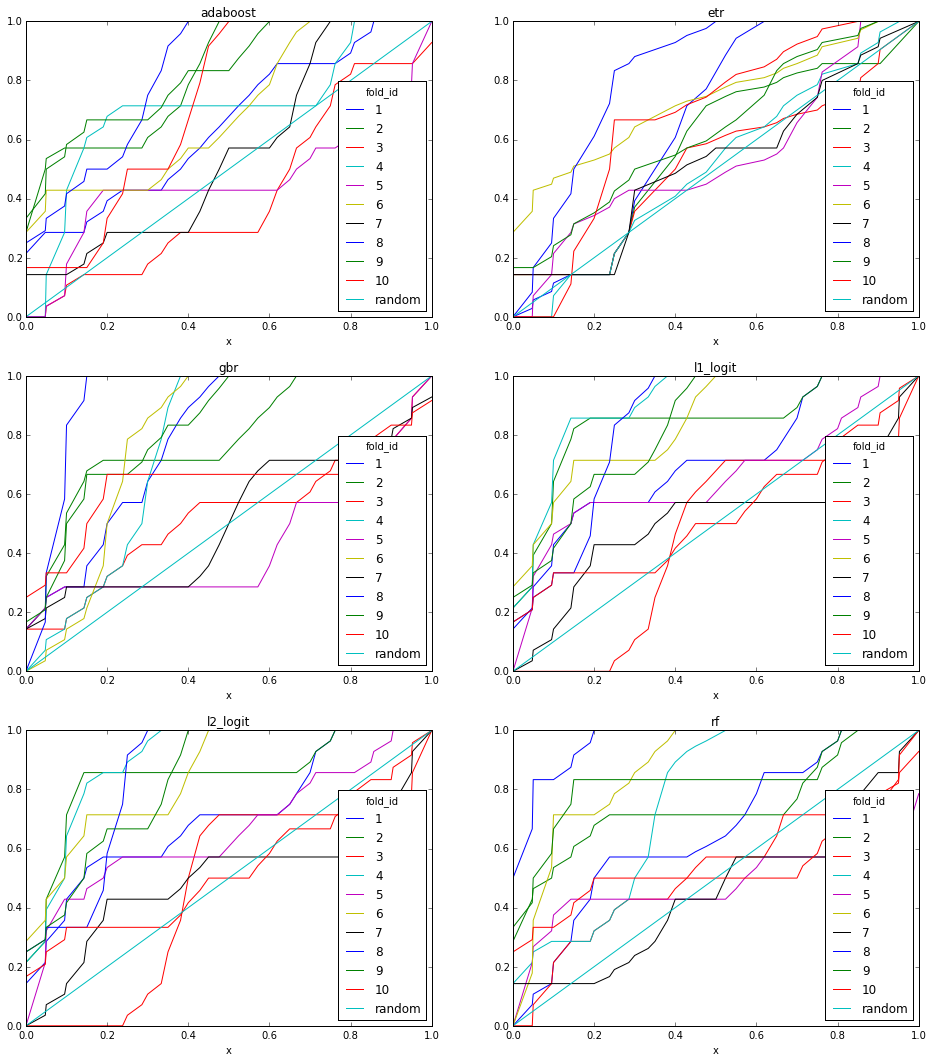

In [35]:
ml_precis.plot_curve(res, plot_size=(8, 6))

### Confusion Matrix

In [36]:
preds = models.summarize_predictions(res)
preds.groupby(['y_pred', 'y_true']).size().unstack().fillna(0)

y_true,0.0,1.0
y_pred,,
0,1138,304
1,92,98


### Model Scores

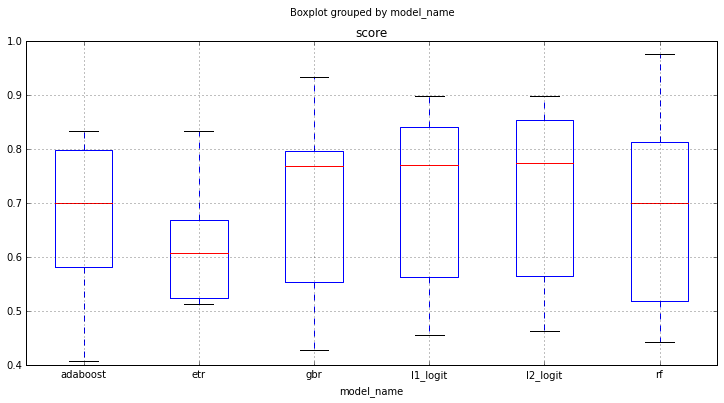

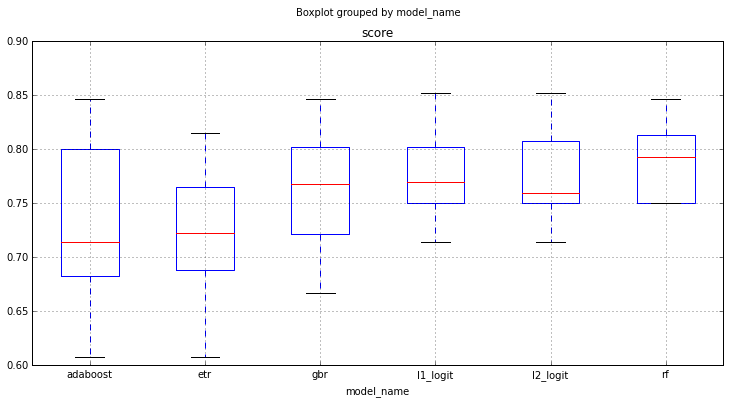

In [37]:
from sklearn.metrics import roc_auc_score, accuracy_score

def score_func(clf, y_true, y_pred):
    return roc_auc_score(y_true, y_pred[:,1])
ml_precis.plot_model_scores(res, score_func, use_proba=True)

def score_func(clf, y_true, y_pred):
    return accuracy_score(y_true, y_pred)
ml_precis.plot_model_scores(res, score_func, use_proba=False)

### Feature Importances

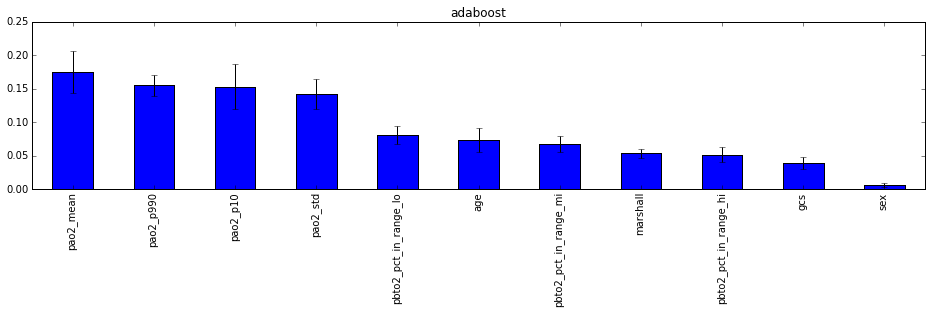

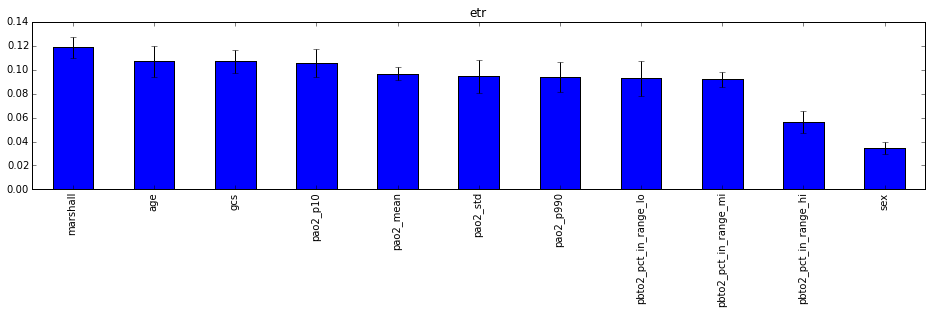

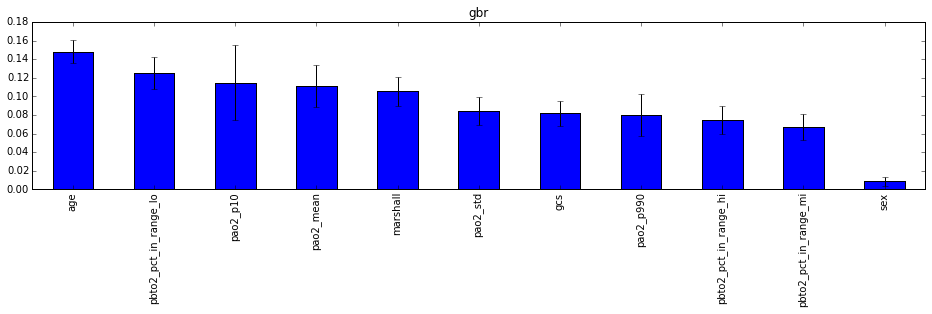

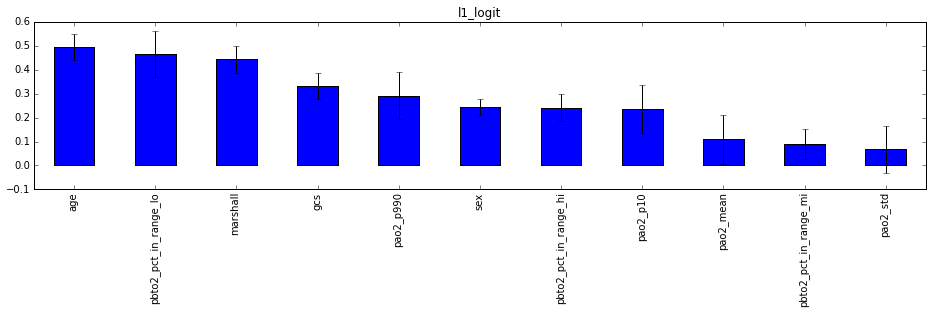

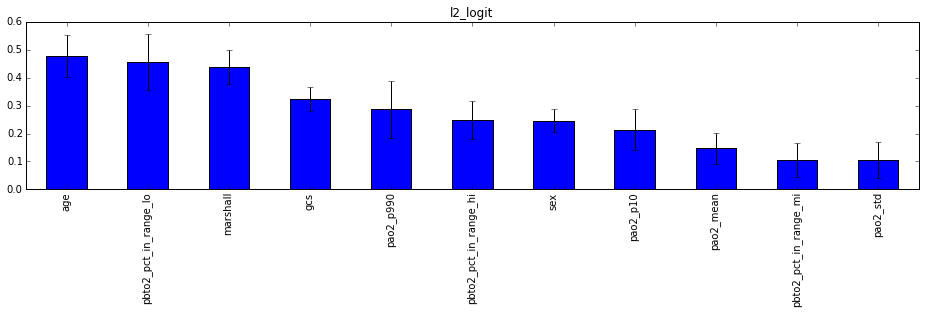

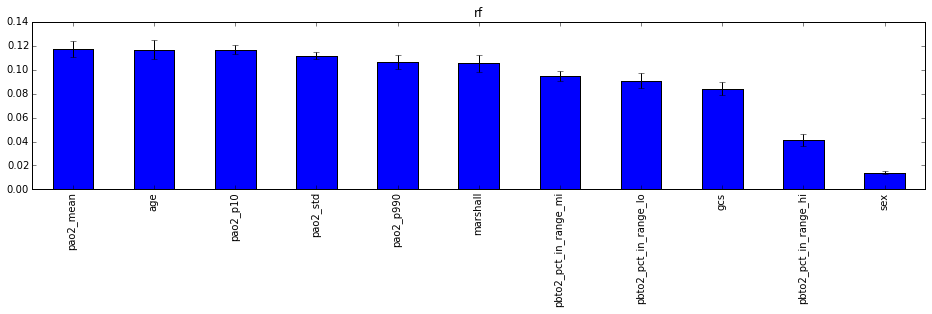

In [38]:
ml_precis.plot_feature_importance(res, figsize=(16,3))
print()

### Feature Average Importances

In [39]:
imp.reload(models)
imp.reload(ml_precis)

<module 'ml.model.summaries' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/model/summaries.py'>

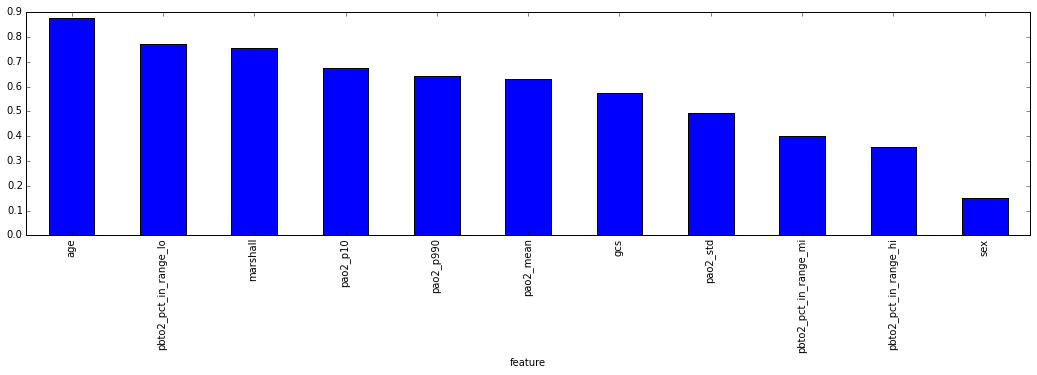

In [40]:
def score_func(clf, y_true, y_pred):
    return accuracy_score(y_true, y_pred)
ml_precis.plot_weighted_feature_importances(res, score_func)

In [46]:
#feats = ['marshall', 'gcs', 'age', 'pao2_p50', 'paco2_p50', 'icp1_p950', 'pbto2_p10', 'map_p950', 'outcome']
feats = ['marshall', 'gcs', 'age', 'pbto2_pct_in_range_lo', 'pbto2_pct_in_range_mi', 'pbto2_pct_in_range_hi', 'outcome']
#feats = ['marshall', 'gcs', 'age', 'pao2_p50', 'outcome']
#feats = ['age', 'sex', 'pbto2_p10', 'outcome']
d_r = d_in[feats].copy()

In [47]:
%%R -i d_r
library(dplyr)
d_r %>% mutate_each(funs(as.numeric)) %>% 
    glm(outcome ~ age + gcs + marshall + pbto2_pct_in_range_lo + pbto2_pct_in_range_mi + pbto2_pct_in_range_hi, family='binomial', data=.) %>% summary


Call:
glm(formula = outcome ~ age + gcs + marshall + pbto2_pct_in_range_lo + 
    pbto2_pct_in_range_mi + pbto2_pct_in_range_hi, family = "binomial", 
    data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2947  -0.8050  -0.5455  -0.1937   2.6141  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -1.3316     0.1716  -7.760  8.5e-15 ***
age                    -0.4624     0.1784  -2.593  0.00952 ** 
gcs                     0.4350     0.1708   2.546  0.01090 *  
marshall               -0.4139     0.1837  -2.253  0.02424 *  
pbto2_pct_in_range_lo  -0.6478     0.2742  -2.363  0.01814 *  
pbto2_pct_in_range_mi  -0.2506     0.2513  -0.997  0.31874    
pbto2_pct_in_range_hi  -0.3367     0.2116  -1.591  0.11162    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 303.69  on 271  degrees of freedom
Residual deviance: 26

# Partial Dependence

24088


(<matplotlib.figure.Figure at 0x110e1e9b0>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1133904e0>])

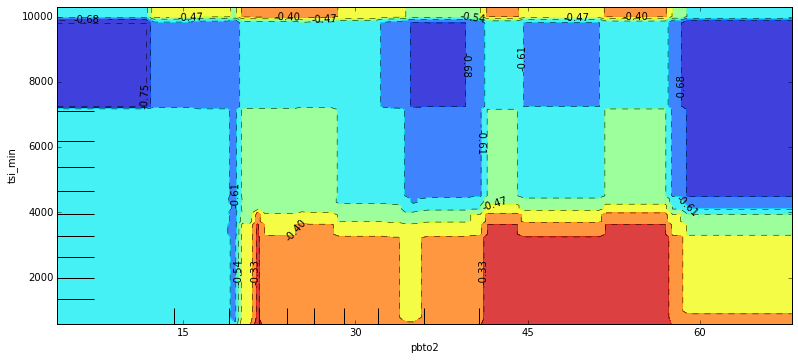

In [56]:
feat = 'pbto2'
#percentiles = [.01, .99]
percentiles = [.01, .99]
dt = d_raw[['tsi_min', 'marshall', 'gcs', 'age', 'gos-3', feat]].dropna()
#dt = d_raw[['pbto2', 'gos-3', 'tsi_min', 'gcs', 'marshall', 'age']].dropna()
print(len(dt))
dt = dt[dt[feat] > 0]
X, y = dt[[c for c in dt if c != 'gos-3']], dt['gos-3']
y = y.apply(lambda x: np.nan if pd.isnull(x) else (1 if x >= 4 else 0))

from sklearn.ensemble import GradientBoostingClassifier
gbr = GradientBoostingClassifier(n_estimators=100)
gbr.fit(X, y)
ml_precis.plot_partial_dependence(gbr, X, [(feat, 'tsi_min')], figsize=(12,8), percentiles=percentiles)

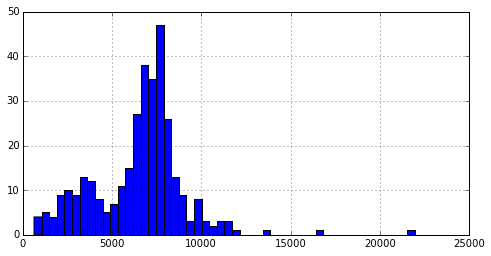

In [178]:
d_raw.groupby('uid').apply(lambda x: x['tsi_min'].max()).hist(bins=50, figsize=(8,4))

In [179]:
dt = d_raw[['pbto2', 'gos-3', 'tsi_min', 'gcs', 'marshall', 'age', 'uid']].dropna()
dt = dt[dt['pbto2'] > 0]
dt.to_csv('/Users/eczech/data/ptbo2/export/cutpoint_modeling.csv', index=False)

# Learning Curves

In [54]:
from sklearn.cross_validation import train_test_split
def get_loss(gbrt, X, y, test_size=.3, **kwargs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, **kwargs)

    gbrt.fit(X_train, y_train)
    n_estimators = len(gbrt.estimators_)

    test_loss = np.empty(n_estimators)
        
    for i, pred in enumerate(gbrt.staged_decision_function(X_test)):
        test_loss[i] = gbrt.loss_(y_test, pred)
        
    return pd.DataFrame({
        'n_estimators': np.arange(n_estimators) + 1,
        'training_loss': gbrt.train_score_,
        'test_loss': test_loss
    })

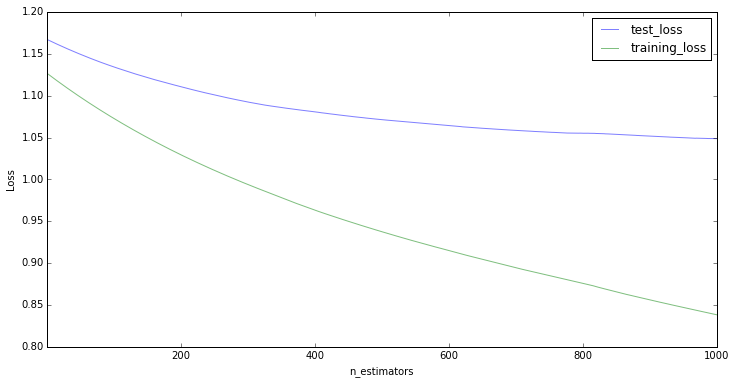

In [73]:
from ml.model import gbrt
from sklearn.ensemble import GradientBoostingClassifier
gbr = GradientBoostingClassifier(n_estimators=1000, learning_rate=.001, subsample=1)
d_loss = get_loss(gbr, X, y, test_size=.3)
gbrt.plot_loss(d_loss)